❗ 未检测到人脸
检测结果（每一行是一个人脸）：


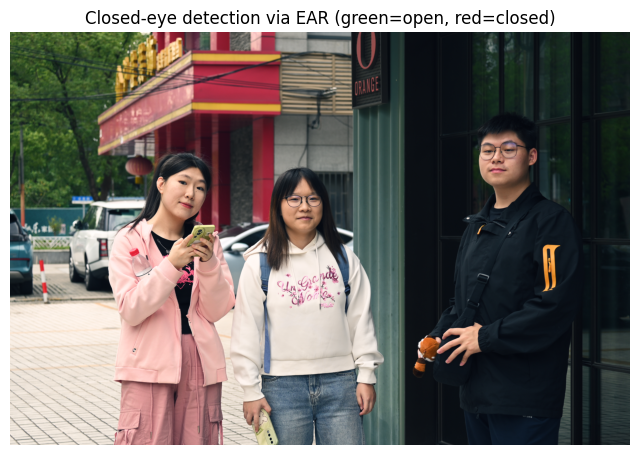

In [5]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# ============================
# 1. EAR 计算函数
# ============================


def eye_aspect_ratio(eye_pts: np.ndarray) -> float:
    """
    eye_pts: shape (6, 2)，依次为 p1...p6 的 (x,y) 像素坐标
    EAR = (||p2 - p6|| + ||p3 - p5||) / (2 * ||p1 - p4||)
    """
    assert eye_pts.shape == (6, 2)
    p1, p2, p3, p4, p5, p6 = eye_pts

    # 欧氏距离
    A = np.linalg.norm(p2 - p6)
    B = np.linalg.norm(p3 - p5)
    C = np.linalg.norm(p1 - p4) + 1e-6  # 避免除零

    ear = (A + B) / (2.0 * C)
    return float(ear)


# ============================
# 2. MediaPipe + EAR 检测函数
# ============================

mp_face_mesh = mp.solutions.face_mesh

# MediaPipe 中常用的一组眼睛关键点索引（左右眼各 6 个）
RIGHT_EYE_IDX = [33, 160, 158, 133, 153, 144]  # 屏幕左边那只眼（人右眼）
LEFT_EYE_IDX = [362, 385, 387, 263, 373, 380]  # 屏幕右边那只眼（人左眼）

def cv_imread(file_path: str) -> np.ndarray:
    """支持中文路径的 cv2 读取."""
    data = np.fromfile(file_path, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read image: {file_path}")
    return img

def detect_closed_eyes_in_image(
    image_path: str,
    ear_threshold: float = 0.23,
):
    """
    读取单张图片，检测所有人脸的左右眼 EAR，并判断是否闭眼。
    返回：
      - result_rgb: 画好半透明眼睛区域和文字标注后的 RGB 图像 (H, W, 3)
      - faces_info: list[dict]，每个 dict 包含当前脸的 EAR 和闭眼布尔值
    """
    # 读取 BGR 图像
    img_bgr = cv_imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")
    h, w, _ = img_bgr.shape

    # 转为 RGB 给 MediaPipe 用
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    faces_info = []
    output_bgr = img_bgr.copy()

    # static_image_mode=True：单张照片，非视频流
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=10,
        refine_landmarks=True,  # 启用眼睛/嘴唇更精细的关键点
        min_detection_confidence=0.5,
    ) as face_mesh:
        results = face_mesh.process(img_rgb)

        if not results.multi_face_landmarks:
            print("❗ 未检测到人脸")
            return cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB), faces_info

        for face_idx, face_landmarks in enumerate(results.multi_face_landmarks):
            # 把归一化坐标转换为像素坐标
            def landmark_to_xy(idx: int) -> np.ndarray:
                lm = face_landmarks.landmark[idx]
                return np.array([lm.x * w, lm.y * h], dtype=np.float32)

            right_eye_pts = np.stack([landmark_to_xy(i) for i in RIGHT_EYE_IDX], axis=0)
            left_eye_pts = np.stack([landmark_to_xy(i) for i in LEFT_EYE_IDX], axis=0)

            right_ear = eye_aspect_ratio(right_eye_pts)
            left_ear = eye_aspect_ratio(left_eye_pts)

            right_closed = right_ear < ear_threshold
            left_closed = left_ear < ear_threshold

            faces_info.append(
                {
                    "face_index": face_idx,
                    "right_ear": right_ear,
                    "left_ear": left_ear,
                    "right_closed": right_closed,
                    "left_closed": left_closed,
                }
            )

            # ======== 可视化：对眼睛区域做“分割高亮” ========
            overlay = output_bgr.copy()

            # 眼睛 polygon 顶点（int 像素）
            right_poly = right_eye_pts.astype(np.int32)
            left_poly = left_eye_pts.astype(np.int32)

            # 闭眼 -> 红色，睁眼 -> 绿色（BGR）
            right_color = (0, 0, 255) if right_closed else (0, 255, 0)
            left_color = (0, 0, 255) if left_closed else (0, 255, 0)

            # 填充多边形
            cv2.fillPoly(overlay, [right_poly], right_color)
            cv2.fillPoly(overlay, [left_poly], left_color)

            # 叠加到原图上（半透明）
            alpha = 0.5
            output_bgr = cv2.addWeighted(overlay, alpha, output_bgr, 1 - alpha, 0)

            # 在眼睛上方写标签
            eyes_all_pts = np.concatenate([right_eye_pts, left_eye_pts], axis=0)
            cx, cy = eyes_all_pts.mean(axis=0).astype(int)
            cy = max(cy - 20, 10)

            text = f"F{face_idx} R:{'C' if right_closed else 'O'}({right_ear:.2f}) L:{'C' if left_closed else 'O'}({left_ear:.2f})"
            cv2.putText(
                output_bgr,
                text,
                (max(cx - 120, 0), cy),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1,
                cv2.LINE_AA,
            )

    # 转回 RGB 给 plt.imshow 用
    result_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)
    return result_rgb, faces_info


# ============================
# 3. 示例：对 ./img/A.png 做闭眼检测并可视化
# ============================

image_path = r"n:\待整理\2025.10.19 上海\Z30_5649.JPG"  # 按你说的路径

result_rgb, faces_info = detect_closed_eyes_in_image(
    image_path,
    ear_threshold=0.18,  # 可以按自己数据在 0.20~0.28 之间微调
)

print("检测结果（每一行是一个人脸）：")
for info in faces_info:
    print(info)

plt.figure(figsize=(8, 8))
plt.imshow(result_rgb)
plt.axis("off")
plt.title("Closed-eye detection via EAR (green=open, red=closed)")
plt.show()
